In [1]:
import sys
sys.path.append('../core')
# importando script
from script_connect_postgres import connect_postgres

In [2]:
import pandas as pd
from decouple import config
from utils.DataVisualization import DataVisualization

# Pipelines:
from sklearn.pipeline import (
    Pipeline,
    make_pipeline
)
from sklearn.compose import (
    make_column_selector as selector,
    ColumnTransformer,
)

# Pre-processing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
)

# Seleção e validação dos modelos:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


# Visualização dos Dados:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from yellowbrick.cluster import kelbow_visualizer

# Modelos:
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import AgglomerativeClustering

# Deployment:
import pickle

# Config:
# from sklearn import set_config
# set_config(transform_output='pandas')

# Segmentando os perfis dos clientes (RFV):

Conectando ao Postgres:

In [3]:
conn = connect_postgres(
    dbname=config('DBNAME'),
    user=config('USER'),
    password=config('PASSWORD'),
    host=config('HOST'),
    port=config('PORT'),
)

DataFrame:

In [4]:
sql_query = """
select
	max(DATE_PART('day', now() - r.rental_date)) as recency,
	count(r.rental_date) as frequency,
	avg(pa.amount) as monetary_value
from rental r

join payment pa on r.rental_id = pa.rental_id
group by r.customer_id
"""

In [5]:
df = pd.read_sql_query(
    sql_query,
    conn
)

/tmp/ipykernel_10521/1402424599.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [6]:
display(df.head())

,recency,frequency,monetary_value
0,490.0,23,3.946522
1,591.0,30,4.856667
2,486.0,22,4.990000
3,491.0,35,4.504286
4,591.0,32,4.990000


## Código:

In [7]:
class SegmentacaoClientes(DataVisualization):
    def gráfico_clusters_scatterplot3d(self, data: list, labels, figsize: tuple, titulo: str):
        plt.figure(figsize=figsize)
        plt.title(titulo)
        ax = plt.axes(projection='3d')
        cores_clusters = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        fg = ax.scatter3D(data[0], data[1], data[2], s=60, c = labels,)

    def gráfico_clusters_scatterplot3d_interativo(self, data, labels, figsize, titulo):
        fig = go.Figure(data=[go.Scatter3d(
            x=data[0],
            y=data[1],
            z=data[2],
            mode='markers',
            marker=dict(
                size=6,
                color=labels,
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        fig.update_layout(
            title=titulo,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis=dict(title='Eixo X'),
                yaxis=dict(title='Eixo Y'),
                zaxis=dict(title='Eixo Z')
            )
        )

        fig.show()

if __name__ == '__main__':
    segmentacao_clientes = SegmentacaoClientes()

## Entedimento Dos Dados:

In [8]:
df.head(3)

,recency,frequency,monetary_value
0,490.0,23,3.946522
1,591.0,30,4.856667
2,486.0,22,4.990000


In [9]:
df.tail(3)

,recency,frequency,monetary_value
596,591.0,33,3.050606
597,488.0,22,4.580909
598,488.0,46,4.707391


In [10]:
segmentacao_clientes.verificando_tipos(
    dataframe=df
)

,Tipos
recency,float64
frequency,int64
monetary_value,float64


In [11]:
segmentacao_clientes.verificando_valores_nulos(
    dataframe=df
)

,Quantidade,Porcentagem
recency,0,0.00%
frequency,0,0.00%
monetary_value,0,0.00%


In [12]:
segmentacao_clientes.descrição(
    dataframe=df,
    vertical=True
)

,count,mean,std,min,10%,15%,25%,50%,75%,85%,95%,99%,max
recency,599.0,513.84,46.67,448.00,482.20,486.00,488.00,490.0,591.00,591.00,591.00,591.00,591.0
frequency,599.0,26.79,5.11,12.00,21.00,22.00,23.00,26.0,30.00,32.00,35.00,40.00,46.0
monetary_value,599.0,4.20,0.46,2.94,3.61,3.71,3.87,4.2,4.52,4.69,4.96,5.24,5.7


In [13]:
segmentacao_clientes.verificando_valores_duplicados(
    dataframe=df
)

,Quantidade,Porcentagem
recency,581,96.99%
frequency,567,94.66%
monetary_value,237,39.57%


## Preparação Dos Dados:

In [14]:
NUMERICAL_FEATURES = ['recency', 'frequency', 'monetary_value']
CATEGORICAL_FEATURES = []
FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = ''

### Seed:

In [15]:
seed = 69

In [16]:
numeric_processor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(), 
)

In [17]:
pre_processing = ColumnTransformer([
    (
        'Scaler', 
        numeric_processor, 
        NUMERICAL_FEATURES
    ),
])

In [18]:
df_test = pre_processing.fit_transform(df)

## Visualização Dos Dados:

1. Existem outliers? Se sim, qual é a quantidade?

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

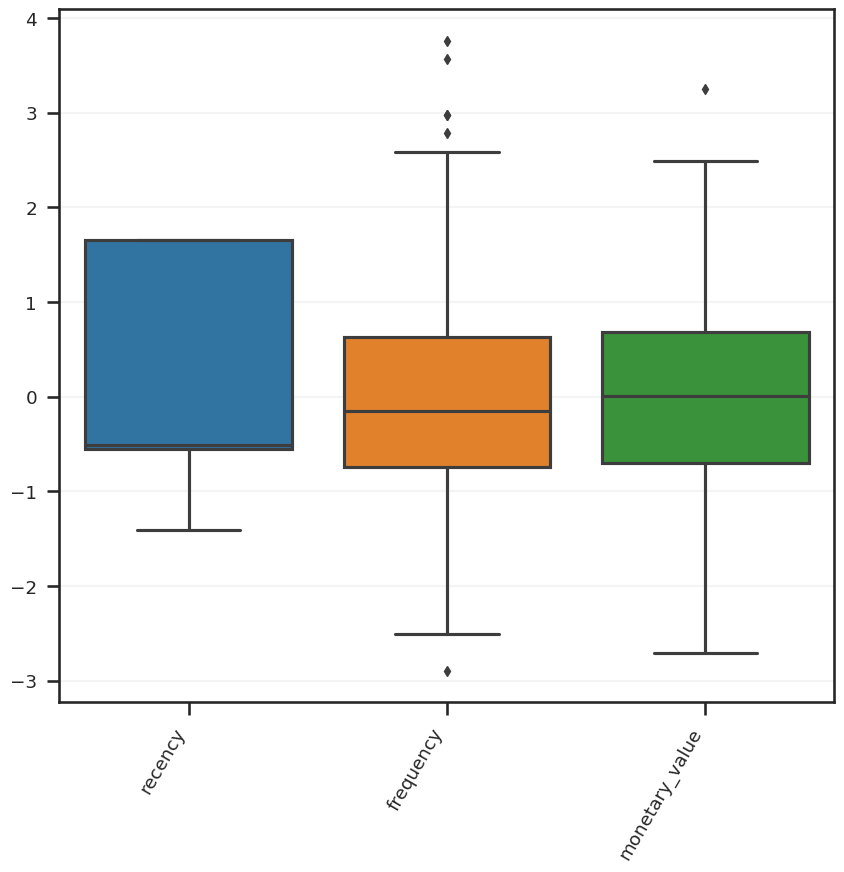

In [19]:
segmentacao_clientes.gráfico_boxplot(
    dataframe=df,
    figsize=(10, 9)
)

2. Como está a distribuição dos dados no dataframe?

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


recency:


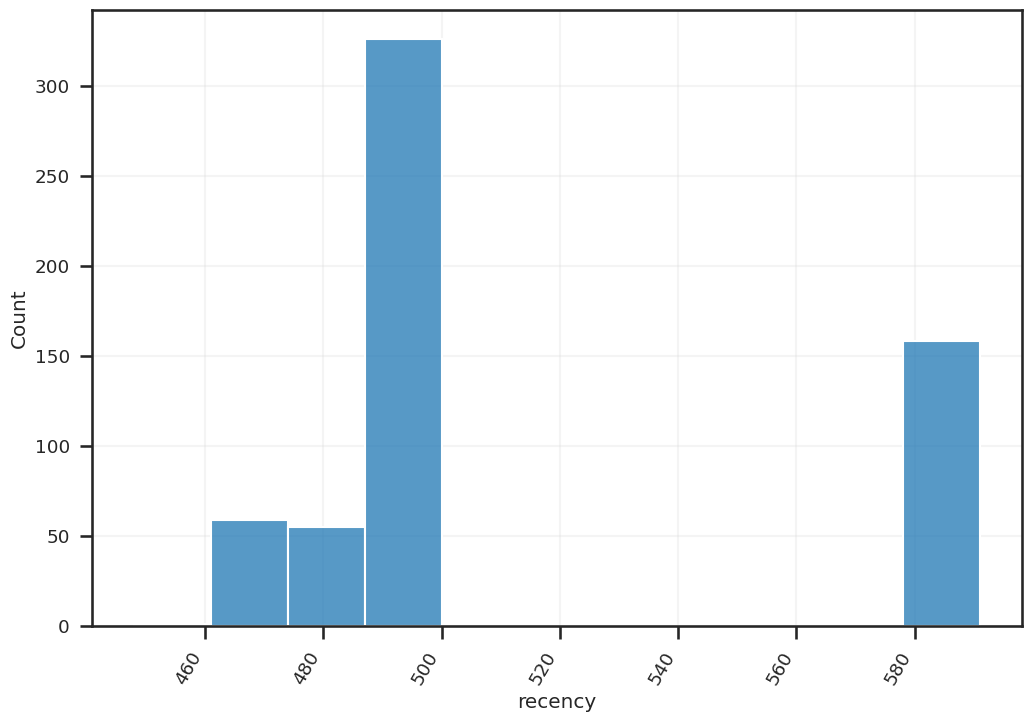

frequency:


/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


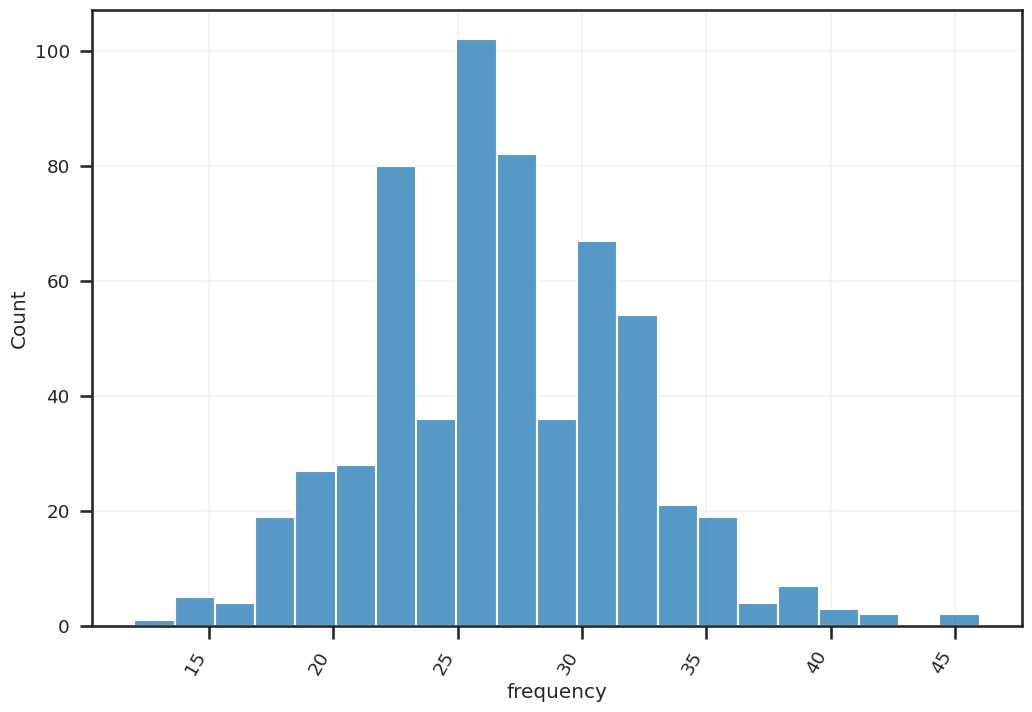

monetary_value:


/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


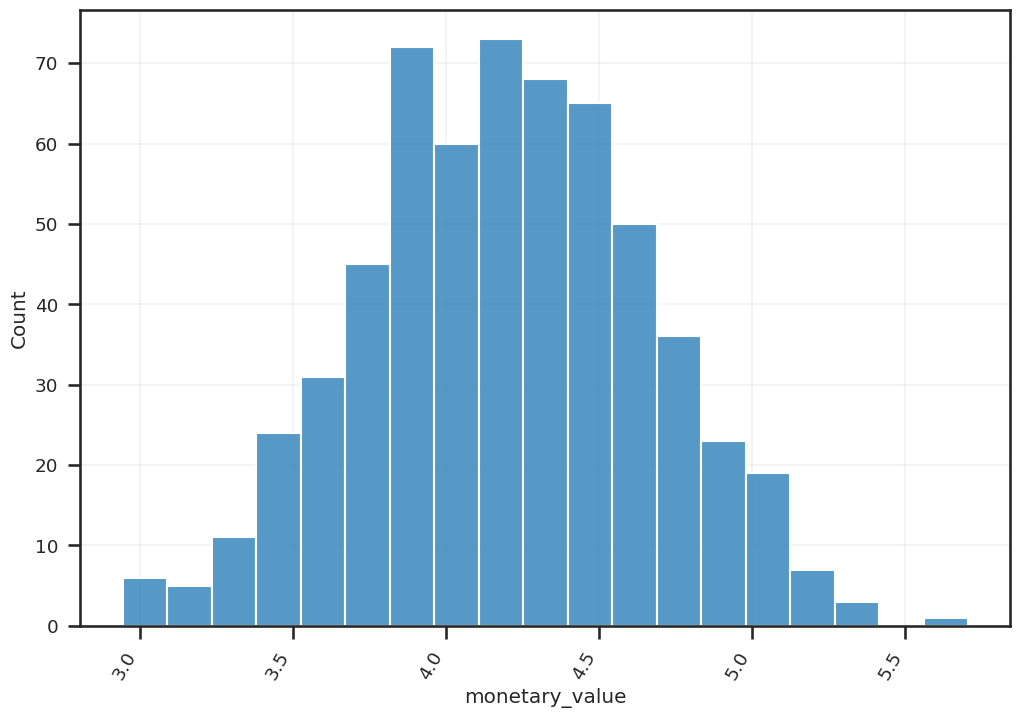

In [20]:
for coluna in FEATURES:
    print(f'{coluna}:')
    segmentacao_clientes.gráfico_histplot(
        dataframe=df,
        coluna=coluna
    )

3. Existe correlação entre as variáveis?

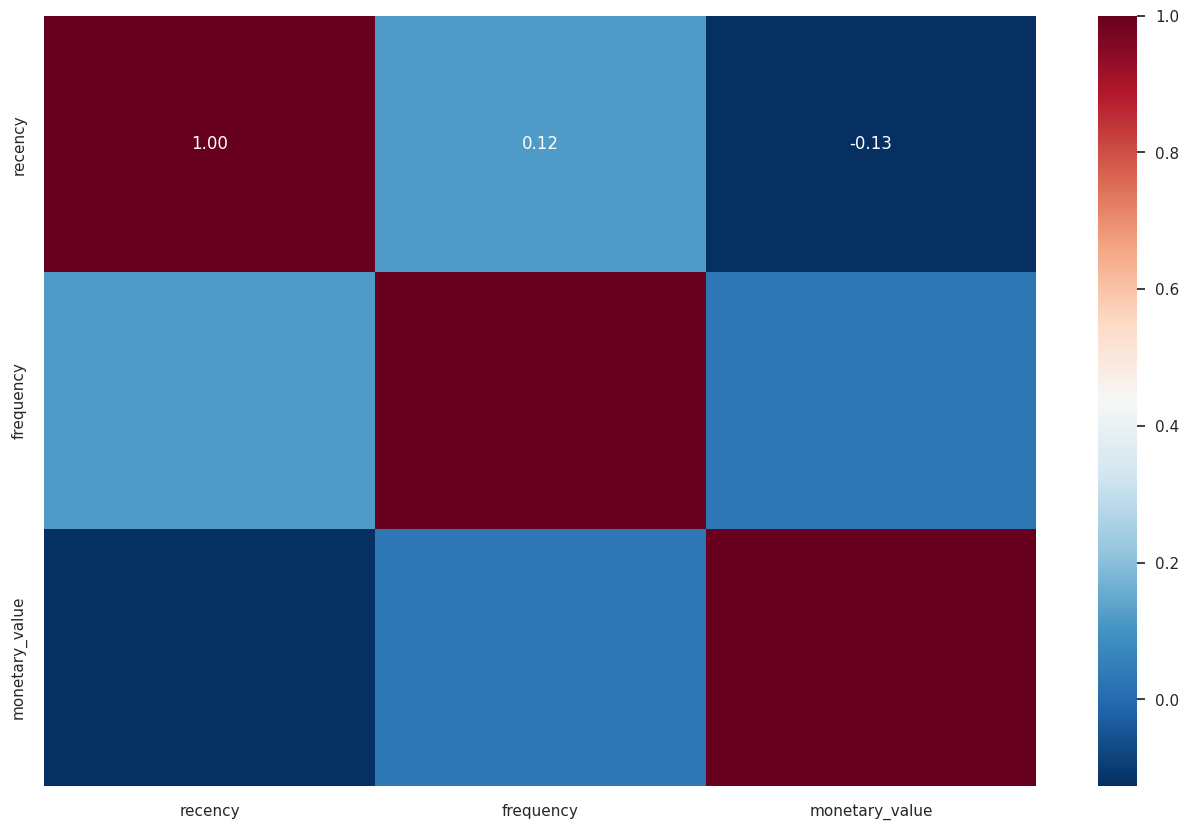

In [21]:
segmentacao_clientes.gráfico_heatmap(
    dataframe=df[FEATURES]
)

Quantos clusters serão necessários?

In [22]:
modelo = KMeans()

In [23]:
x = df[FEATURES]

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will 

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will 

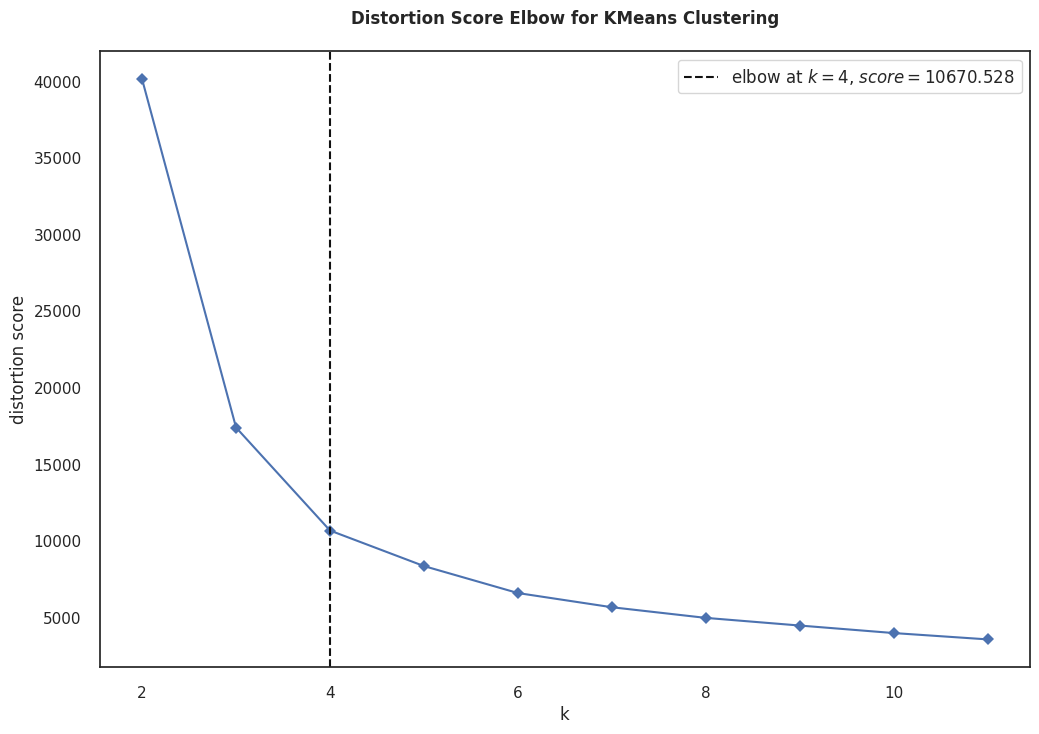

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=11), k=11, timings=False)

In [24]:
kelbow_visualizer(modelo, x, k=11, timings=False)

## Modelo:

### Pipelines:

In [25]:
kmeans_pipeline = Pipeline([
    ('pre_processing', pre_processing),
    ('kmeans', KMeans(n_clusters=4, init='k-means++', random_state=seed))
])

kmeans_pipeline.fit(df)

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('Scaler',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary_value'])])),
                ('kmeans', KMeans(n_clusters=4, random_state=69))])

In [26]:
dbscan_pipeline = Pipeline([
    ('pre_processing', pre_processing),
    ('dbscan', DBSCAN(eps=0.5, min_samples=5))
])

dbscan_pipeline.fit(df)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('Scaler',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary_value'])])),
                ('dbscan', DBSCAN())])

In [27]:
meanshift_pipeline = Pipeline([
    ('pre_processing', pre_processing),
    ('meanshift', MeanShift(bandwidth=0.5))
])

meanshift_pipeline.fit(df)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('Scaler',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary_value'])])),
                ('meanshift', MeanShift(bandwidth=0.5))])

Qual foi o resultado dos clusters?

/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


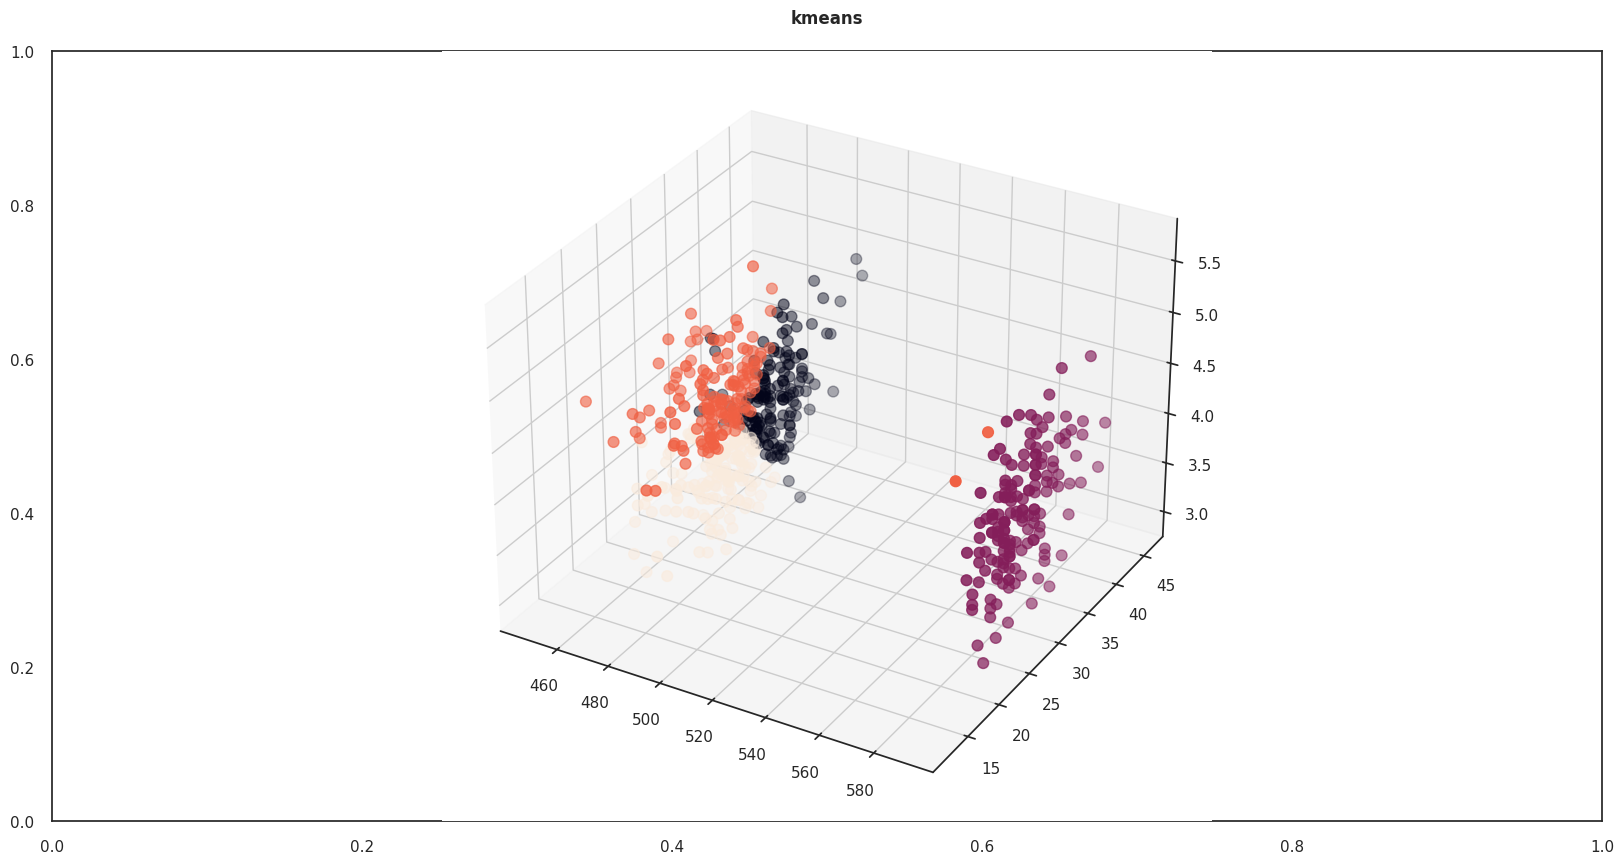

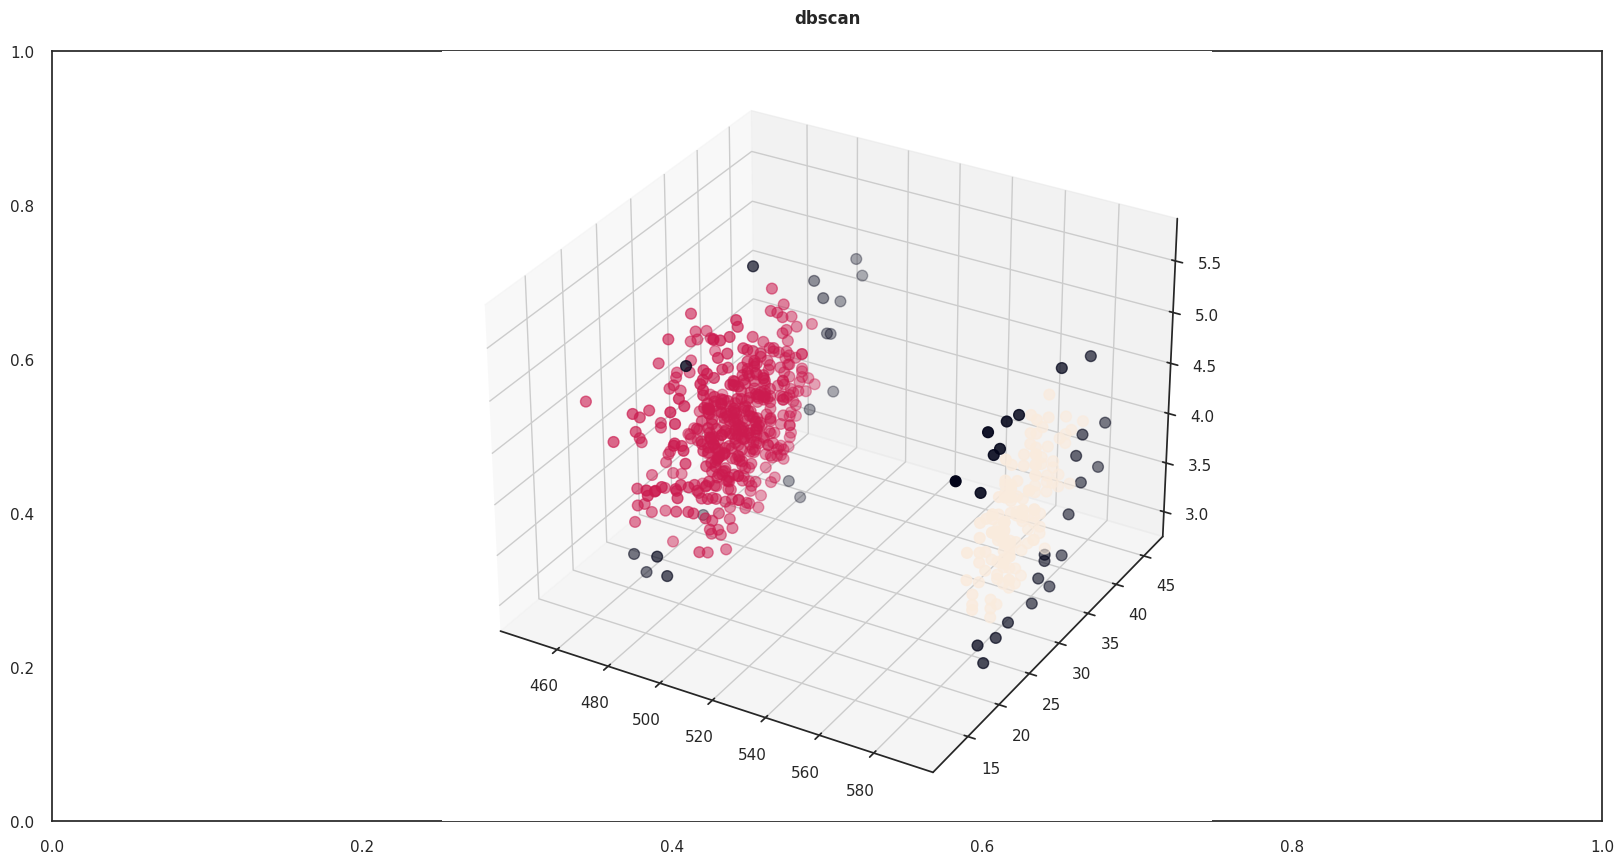

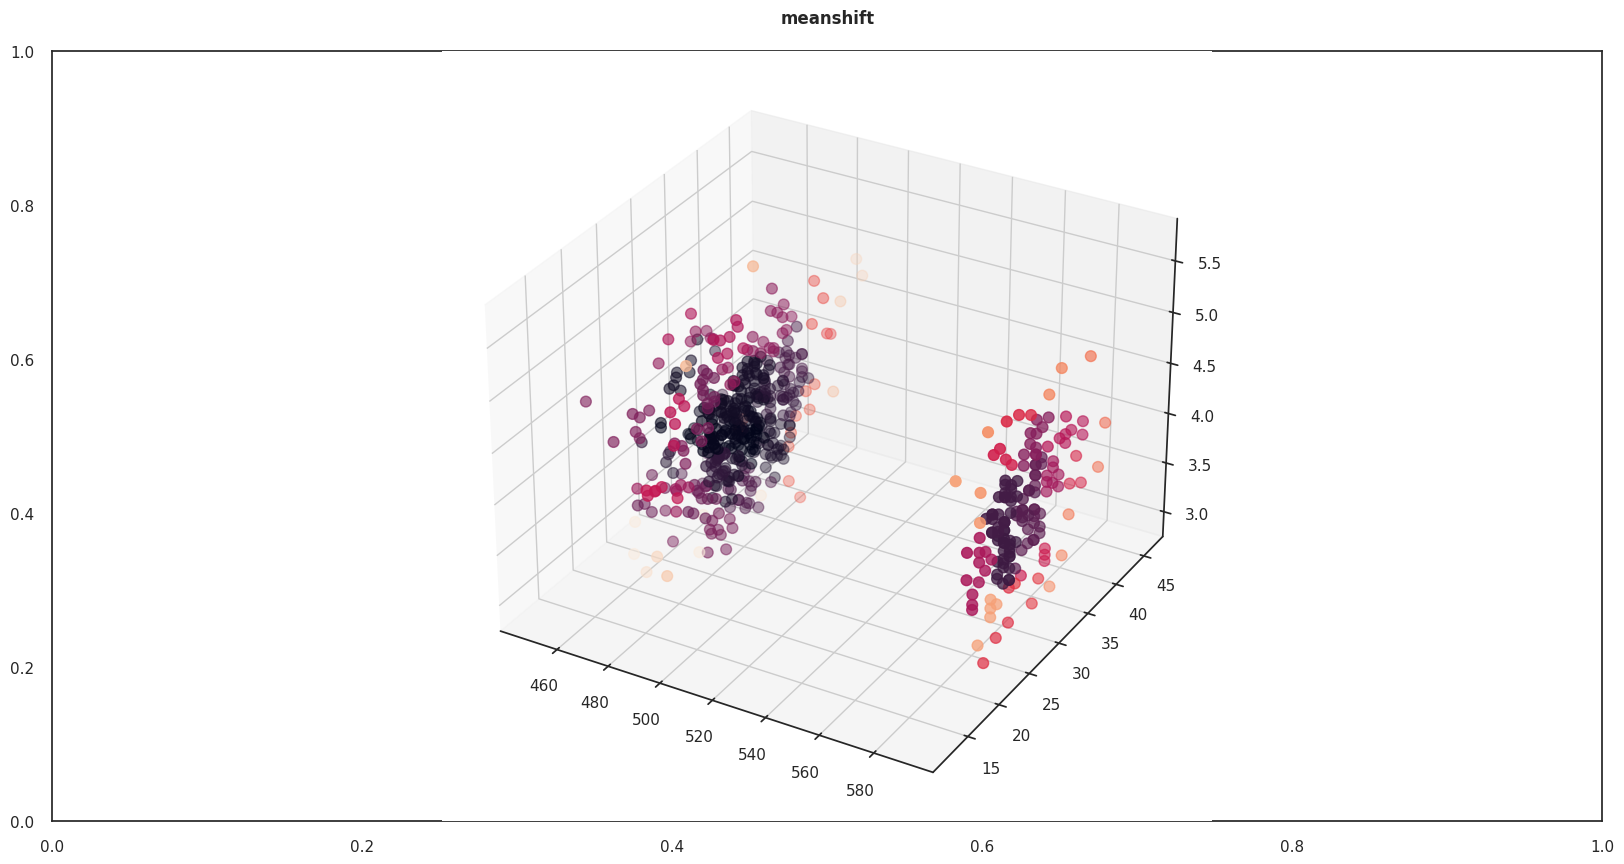

In [28]:
for pipeline, name_model in zip([kmeans_pipeline, dbscan_pipeline, meanshift_pipeline], ['kmeans', 'dbscan', 'meanshift']):
    try:
        centroids = pipeline[name_model].cluster_centers_
        labels = pipeline[name_model].labels_
        inertia = pipeline[name_model].inertia_
        predict = pipeline[name_model].fit_predict(df)
        
    except AttributeError:
        labels = pipeline[name_model].labels_

    segmentacao_clientes.gráfico_clusters_scatterplot3d(
        data=[df['recency'],df['frequency'],df['monetary_value']],
        labels=labels,
        figsize=(20,10),
        titulo=name_model
    )

Visualizando features:

In [29]:
centroids = kmeans_pipeline['kmeans'].cluster_centers_

In [30]:
df_center = pd.DataFrame(centroids, columns=FEATURES)

In [31]:
centroids = pre_processing.fit_transform(df_center)

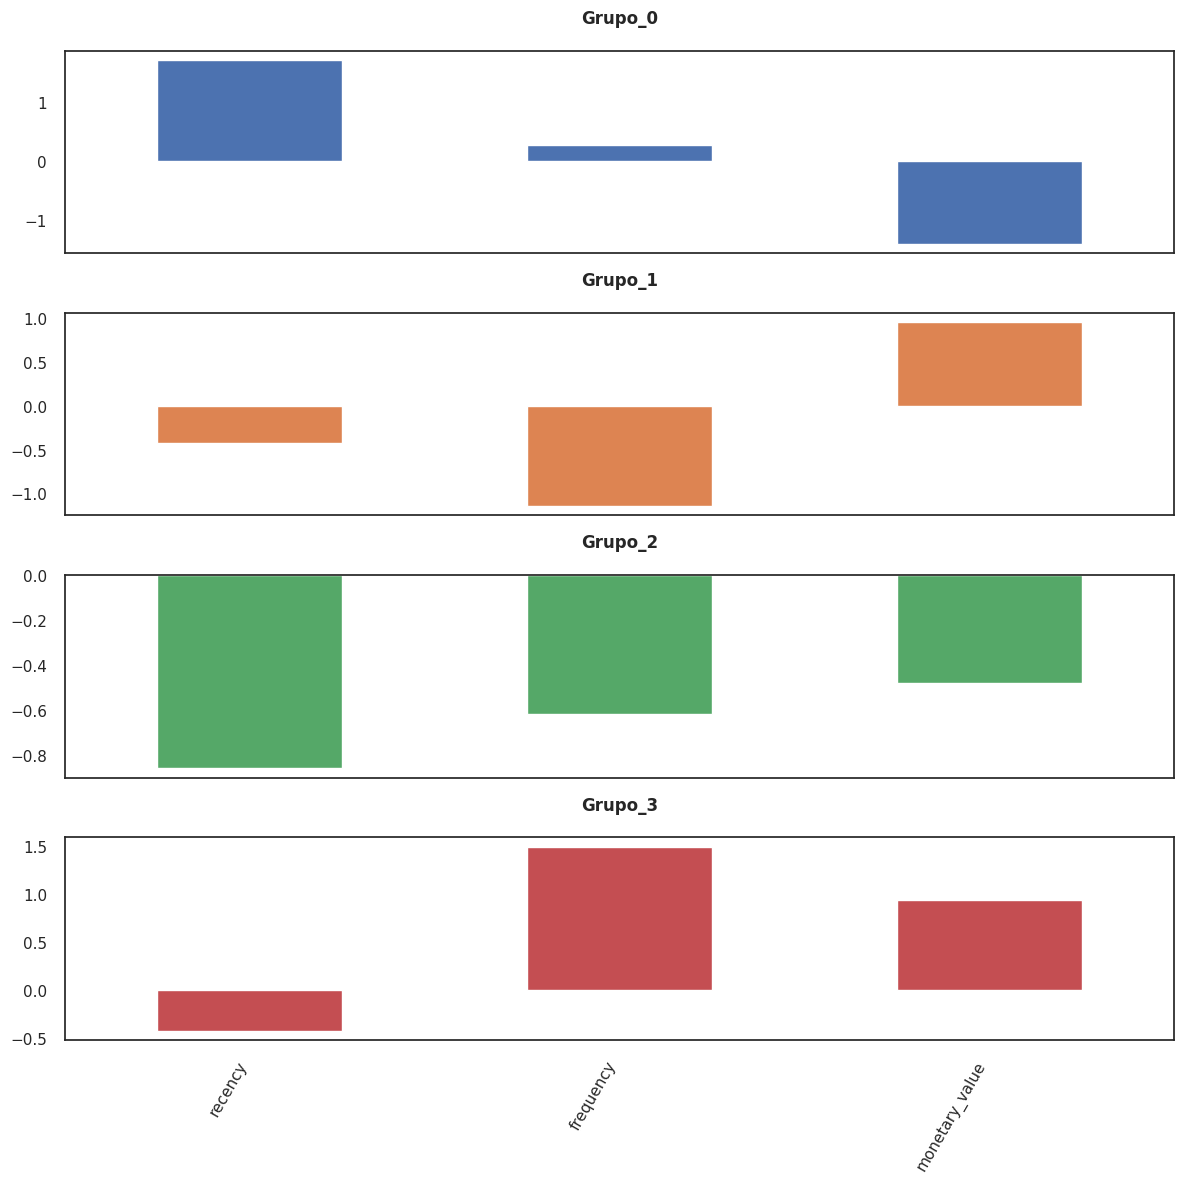

In [32]:
(
  pd.DataFrame(centroids, columns=FEATURES)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Visualizando os grupos:

In [33]:
centroids = pre_processing.fit_transform(df_center)

In [34]:
df_center = pd.DataFrame(centroids, columns=FEATURES)

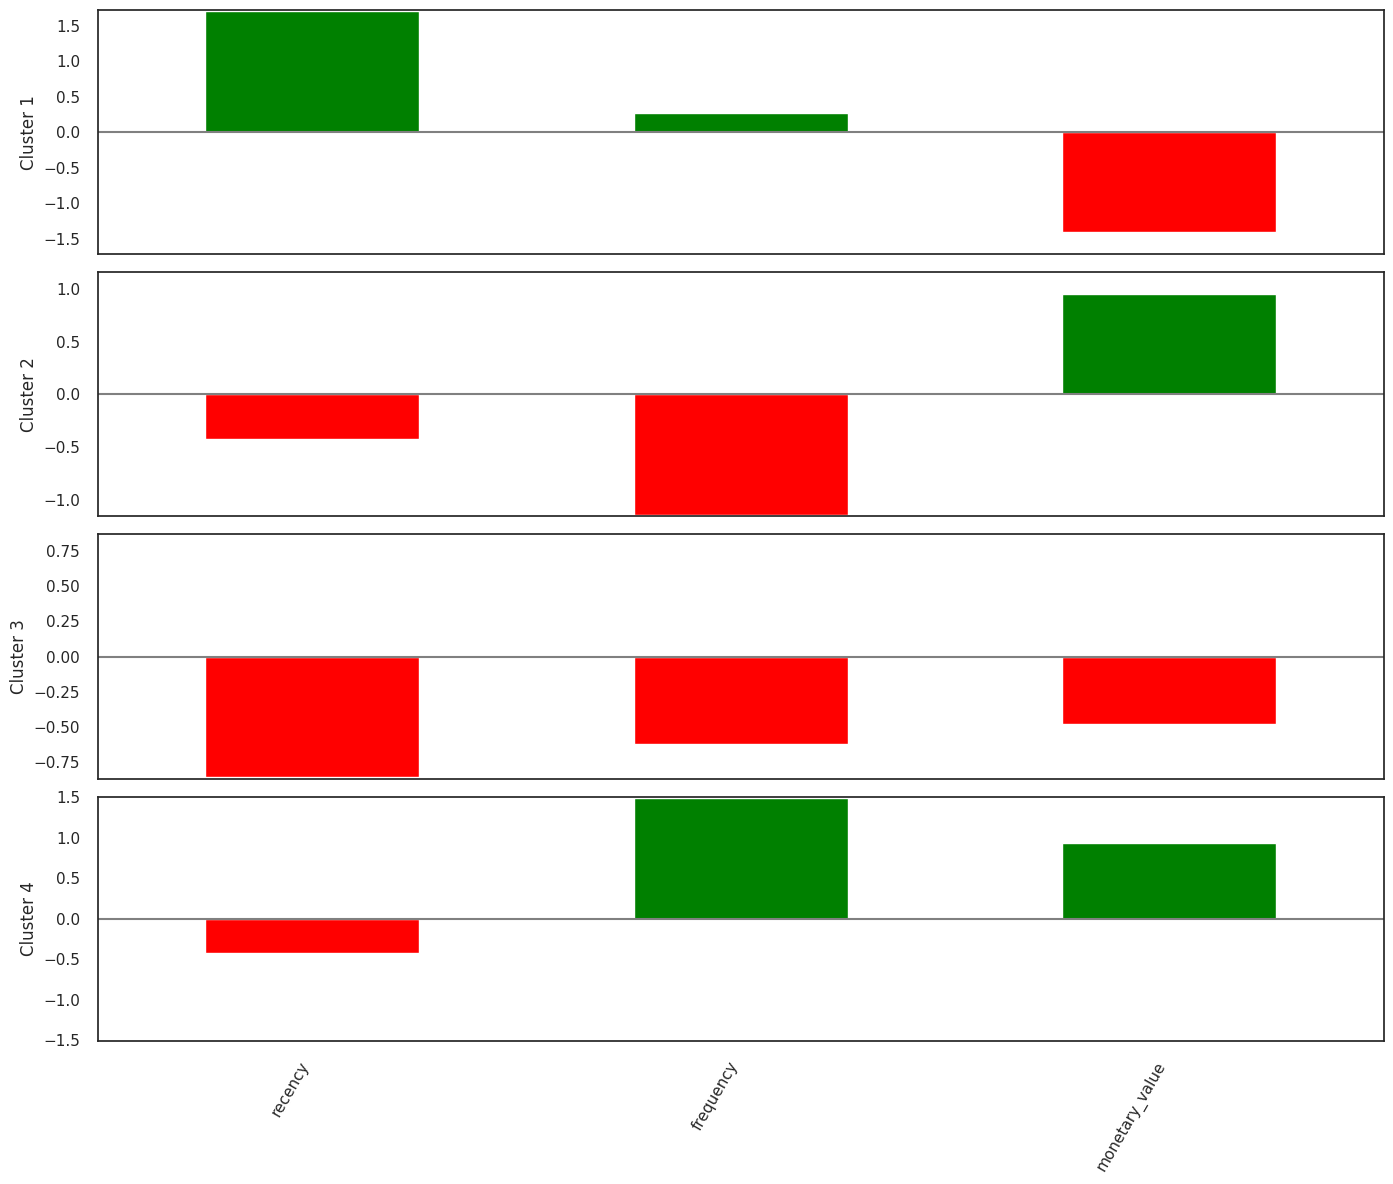

In [35]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig, axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i, ax in enumerate(axes):
  center = df_center.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()



## Deployment:

In [36]:
path = r'../models/clustering_model.pkl' 

with open(path, 'wb') as file:
    pickle.dump(kmeans_pipeline, file)

In [37]:

with open(path, 'rb') as file:
    model = pickle.load(file)

In [38]:

df_input = pd.DataFrame([dict(recency=91, frequency=22, monetary_value=77)])
print(model.predict(df_input)[0])

2


/home/guerrlr0/Documentos/010101110101/Programação/Samuel/Projetos/Python/exploratory_analysis/Btime_Technical_Test/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
